In [3]:
!pip install opencv-contrib-python Pillow matplotlib torch torchvision

In [4]:
import os
import cv2
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
import shutil
import itertools
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.utils import make_grid

**Routine to Download the Images from GitHub**

In [5]:
# Download the files if not already present
import os
import zipfile
import requests
from io import BytesIO

local_dir = "Images"

# URL of the GitHub repo's zip file
github_repo_url = "https://github.com/morrissoftware1229/MonetGAN/archive/refs/heads/main.zip"

# Check if the directory exists and contains any files
if not os.path.exists(local_dir) or not os.listdir(local_dir):
    print("Downloading and extracting Images folder...")

    # Fetch the data from the GitHub
    response = requests.get(github_repo_url)
    zip_file = zipfile.ZipFile(BytesIO(response.content))

    # Target Repo's folder
    target_folder = "MonetGAN-main/Images/"

    # Extract only the specific folder from the zip
    for file in zip_file.namelist():
        if file.startswith(target_folder):
            zip_file.extract(file)

    # Rename the extracted folder for easier access (optional)
    os.rename("MonetGAN-main/Images", local_dir)

    print("Download and extraction complete.")
else:
    print("Images folder already exists. No download needed.")

# List the contents of the folder to verify (optional)
print("Contents of the Images folder:")
!ls {local_dir}

Download and extraction complete.
Contents of the Images folder:
monet_jpg  monet_tfrec	photo_jpg  photo_tfrec


In [6]:
BATCH_SIZE = 5
MONET_IMAGES_PATH = "./Images/monet_jpg/"
TEST_IMAGES_PATH = "./Images/photo_jpg/"

lr = 0.0001
beta1 = 0.5
beta2 = 0.996
n_epoches = 90
decay_epoch = 40
display_epoch = 25

In [7]:
# Check for CUDA availability and define the Tensor type accordingly
cuda_available = torch.cuda.is_available()
Tensor = torch.cuda.FloatTensor if cuda_available else torch.Tensor
print(f'CUDA Available: {cuda_available}')

CUDA Available: True


In [8]:
transforms_dataset = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [9]:
class ImageDataset(Dataset):
    def __init__(self, directory_x, directory_y, test=False, transforms=None):
        self.transforms = transforms

        if test:
            self.monet_images_X = [directory_x + "/" + name for name in sorted(os.listdir(directory_x))[250:]]
            self.test_images_Y = [directory_y + "/" + name for name in sorted(os.listdir(directory_y))[250:301]]
        else:
            self.monet_images_X = [directory_x + "/" + name for name in sorted(os.listdir(directory_x))[:250]]
            self.test_images_Y = [directory_y + "/" + name for name in sorted(os.listdir(directory_y))[:250]]

    def __len__(self):
        return len(self.monet_images_X)

    def __getitem__(self, index):
        x_img =  Image.open(self.monet_images_X[index])
        y_img =  Image.open(self.test_images_Y[index])

        if self.transforms is not None:
            x_img = self.transforms(x_img)
            y_img = self.transforms(y_img)
        return x_img, y_img

In [10]:
train_loader = DataLoader(
    ImageDataset(directory_x=MONET_IMAGES_PATH, directory_y=TEST_IMAGES_PATH, test=False, transforms=transforms_dataset),
    batch_size = BATCH_SIZE,
    shuffle = True
)

test_loader = DataLoader(
    ImageDataset(directory_x=MONET_IMAGES_PATH, directory_y=TEST_IMAGES_PATH, test=True, transforms=transforms_dataset),
    batch_size = BATCH_SIZE,
    shuffle = False
)

In [11]:
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        self.scale_factor = 16

        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ZeroPad2d((1,0,1,0)),
            nn.Conv2d(512, 1, 4, padding=1),
        )

    def forward(self, x):
        return self.model(x)

In [12]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels)
        )

    def forward(self, x):
        return x + self.block(x)

class GeneratorResNet(nn.Module):
    def __init__(self, in_channels, num_residual_blocks=9):
        super(GeneratorResNet, self).__init__()

        self.initial = nn.Sequential(
            nn.ReflectionPad2d(in_channels),
            nn.Conv2d(in_channels, 64, 2 * in_channels + 1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.downsample_blocks = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.residual_blocks = nn.Sequential(*[ResidualBlock(256) for _ in range(num_residual_blocks)])

        self.upsample_blocks = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, 3, stride=1, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.output = nn.Sequential(
            nn.ReflectionPad2d(in_channels),
            nn.Conv2d(64, in_channels, 2 * in_channels + 1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.downsample_blocks(x)
        x = self.residual_blocks(x)
        x = self.upsample_blocks(x)
        return self.output(x)

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import itertools
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

class CycleGAN(nn.Module):
    def __init__(self, in_channels, num_residual_blocks=9):
        super(CycleGAN, self).__init__()
        # Initialize the generator and discriminator models
        self.generator_XtoY = GeneratorResNet(in_channels, num_residual_blocks)
        self.generator_YtoX = GeneratorResNet(in_channels, num_residual_blocks)
        self.discriminator_X = Discriminator(in_channels)
        self.discriminator_Y = Discriminator(in_channels)

        if cuda_available:
          for model in (self.generator_XtoY, self.generator_YtoX, self.discriminator_X, self.discriminator_Y):
              model.cuda()
        
        # Losses
        self.gan_loss = nn.MSELoss().cuda()
        self.cycle_loss = nn.L1Loss().cuda()
        self.identity_loss = nn.L1Loss().cuda()

    def forward(self, x, y):
        fake_y = self.generator_XtoY(x)
        fake_x = self.generator_YtoX(y)
        return fake_y, fake_x


    def calculate_loss(self, x, y, reconstructed_X, reconstructed_Y, fake_X, fake_Y):
        # Identity loss (Y -> Y and X -> X)
        identity_Y = self.generator_XtoY(y)
        identity_X = self.generator_YtoX(x)
        loss_identity_Y = self.identity_loss(identity_Y, y)
        loss_identity_X = self.identity_loss(identity_X, x)

        # Adversarial loss for both generators
        loss_G_XtoY = self.gan_loss(self.discriminator_Y(fake_Y), torch.ones_like(self.discriminator_Y(fake_Y)))
        loss_G_YtoX = self.gan_loss(self.discriminator_X(fake_X), torch.ones_like(self.discriminator_X(fake_X)))

        # Cycle consistency loss
        loss_cycle_XYX = self.cycle_loss(reconstructed_X, x)
        loss_cycle_YXY = self.cycle_loss(reconstructed_Y, y)

        # Calculate total generator loss
        total_loss_G = loss_G_XtoY + loss_G_YtoX + loss_cycle_XYX + loss_cycle_YXY + loss_identity_Y + loss_identity_X

        # Calculate Discriminator X loss
        loss_real_X = self.gan_loss(self.discriminator_X(x), torch.ones_like(self.discriminator_X(x)))
        loss_fake_X = self.gan_loss(self.discriminator_X(fake_X.detach()), torch.zeros_like(self.discriminator_X(x)))
        total_loss_D_X = (loss_real_X + loss_fake_X) / 2

        # Calculate Discriminator Y loss
        loss_real_Y = self.gan_loss(self.discriminator_Y(y), torch.ones_like(self.discriminator_X(y)))
        loss_fake_Y = self.gan_loss(self.discriminator_Y(fake_Y.detach()), torch.zeros_like(self.discriminator_X(y)))
        total_loss_D_Y = (loss_real_Y + loss_fake_Y) / 2

        torch.cuda.empty_cache() # Attemting to clear cuda cache

        return total_loss_G, total_loss_D_X, total_loss_D_Y

    def train_step(self, x, y, optimizer_G, optimizer_D_X, optimizer_D_Y):
        x, y = x.type(Tensor), y.type(Tensor)

        # Generate fake images
        fake_Y = self.generator_XtoY(x)
        fake_X = self.generator_YtoX(y)

        # Reconstruct images (Cycle Consistency)
        reconstructed_X = self.generator_YtoX(fake_Y)
        reconstructed_Y = self.generator_XtoY(fake_X)

        # Calculate losses
        total_loss_G, total_loss_D_X, total_loss_D_Y = self.calculate_loss(x, y, reconstructed_X, reconstructed_Y, fake_X, fake_Y)

        # Update generators
        optimizer_G.zero_grad()
        total_loss_G.backward()
        optimizer_G.step()

        # Update Discriminator X
        optimizer_D_X.zero_grad()
        total_loss_D_X.backward()
        optimizer_D_X.step()

        # Update Discriminator Y
        optimizer_D_Y.zero_grad()
        total_loss_D_Y.backward()
        optimizer_D_Y.step()

        torch.cuda.empty_cache() # Attemting to clear cuda cache
        return total_loss_G, total_loss_D_X, total_loss_D_Y, fake_X, fake_Y

    # Reference for Training Logic: https://blog.jaysinha.me/train-your-first-cyclegan-for-image-to-image-translation/
    def train(self, dataloader, epochs, lr, beta1, beta2, decay_epoch, display_epoch: int=10):
        # Create optimizers for the generators and discriminators
        optimizer_G = torch.optim.Adam(itertools.chain(self.generator_XtoY.parameters(), self.generator_YtoX.parameters()), lr=lr, betas=(beta1, beta2))
        optimizer_D_X = torch.optim.Adam(self.discriminator_X.parameters(), lr=lr, betas=(beta1, beta2))
        optimizer_D_Y = torch.optim.Adam(self.discriminator_Y.parameters(), lr=lr, betas=(beta1, beta2))

        # Create learning rate schedulers
        lr_lambda = lambda epoch: 1.0 - max(0, epoch - decay_epoch) / (epochs - decay_epoch)
        lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lr_lambda)
        lr_scheduler_D_X = torch.optim.lr_scheduler.LambdaLR(optimizer_D_X, lr_lambda=lr_lambda)
        lr_scheduler_D_Y = torch.optim.lr_scheduler.LambdaLR(optimizer_D_Y, lr_lambda=lr_lambda)

        # Training loop
        for epoch in range(epochs):
            for batch_idx, (x, y) in enumerate(dataloader):
                x, y = x.type(Tensor), y.type(Tensor)

                # Perform a training step
                total_loss_G, total_loss_D_X, total_loss_D_Y, fake_X, fake_Y = self.train_step(x, y, optimizer_G, optimizer_D_X, optimizer_D_Y)

                # Get current learning rates
                current_lr_G = lr_scheduler_G.get_last_lr()[0]
                current_lr_D_X = lr_scheduler_D_X.get_last_lr()[0]
                current_lr_D_Y = lr_scheduler_D_Y.get_last_lr()[0]

                # Show Progress (Losses and Learning Rate)
                if batch_idx % display_epoch == 0:
                    print(f'Epoch: {epoch}/{epochs}, Batch: {batch_idx}/{len(dataloader)}, '
                          f'Generator LR: {current_lr_G:.6f}, Discriminator X LR: {current_lr_D_X:.6f}, '
                          f'Discriminator Y LR: {current_lr_D_Y:.6f}, '
                          f'Generator Loss: {total_loss_G.item():.4f}, '
                          f'Discriminator X Loss: {total_loss_D_X.item():.4f}, '
                          f'Discriminator Y Loss: {total_loss_D_Y.item():.4f}')
                
                # Update learning rates
                lr_scheduler_G.step()
                lr_scheduler_D_X.step()
                lr_scheduler_D_Y.step()
                
            # Visualization and checkpointing
            if epoch % display_epoch == 0:
                self.sample_images(x, y)
                self.save_model(f"cyclegan_epoch_{epoch}.pth")

    def save_model(self, filename):
        torch.save(self.state_dict(), filename)

    def load_model(self, filename):
        model_state = torch.load(filename, map_location="cuda")
        self.load_state_dict(model_state)
        self.cuda()

    def sample_images(self, real_X, real_Y):
        self.generator_XtoY.eval()
        self.generator_YtoX.eval()

        real_X = real_X.type(Tensor)
        fake_Y = self.generator_XtoY(real_X).detach()

        real_Y = real_Y.type(Tensor)
        fake_X = self.generator_YtoX(real_Y).detach()

        ncols = real_X.size(0)
        real_X_grid = make_grid(real_X, nrow=ncols, normalize=True)
        fake_Y_grid = make_grid(fake_Y, nrow=ncols, normalize=True)
        real_Y_grid = make_grid(real_Y, nrow=ncols, normalize=True)
        fake_X_grid = make_grid(fake_X, nrow=ncols, normalize=True)

        fig, axs = plt.subplots(2, 2, figsize=(10, 5))

        axs[0, 0].imshow(real_X_grid.permute(1, 2, 0).cpu().numpy())
        axs[0, 0].set_title("Real Images from Domain X")
        axs[0, 0].axis('off')

        axs[0, 1].imshow(fake_Y_grid.permute(1, 2, 0).cpu().numpy())
        axs[0, 1].set_title("Generated Images to Domain Y")
        axs[0, 1].axis('off')

        axs[1, 0].imshow(real_Y_grid.permute(1, 2, 0).cpu().numpy())
        axs[1, 0].set_title("Real Images from Domain Y")
        axs[1, 0].axis('off')

        axs[1, 1].imshow(fake_X_grid.permute(1, 2, 0).cpu().numpy())
        axs[1, 1].set_title("Generated Images to Domain X")
        axs[1, 1].axis('off')

        plt.tight_layout(h_pad=0.0, w_pad=1.0)
        plt.show()

        def evaluate(self, image_path):
            self.generator_XtoY.eval()  # Assuming this is the generator you want to use

            # Load and preprocess the image
            image = Image.open(image_path).convert('RGB')
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
            image = transform(image).unsqueeze(0).to(self.device)

            # Generate the output
            with torch.no_grad():
                output = self.generator_XtoY(image)

            # Postprocess and display the images
            image = self.to_pil(image.cpu().squeeze(0))
            output = self.to_pil(output.cpu().squeeze(0))

            plt.subplot(1, 2, 1)
            plt.imshow(image)
            plt.title('Original Image')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(output)
            plt.title('Generated Image')
            plt.axis('off')

            plt.show()

        def submission(self, test_path):
            os.makedirs('submission', exist_ok=True)
            for filename in os.listdir(test_path):
                file_path = os.path.join(test_path, filename)
                output = self.evaluate(file_path)

                # Save the output image
                output.save(os.path.join('submission', filename))


**Visualize a photo example and a Monet painting example**

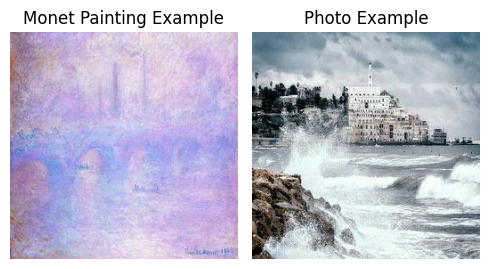

In [14]:
# Load the first images from each dataset
monet_image = Image.open(os.path.join(MONET_IMAGES_PATH, os.listdir(MONET_IMAGES_PATH)[0]))
test_image = Image.open(os.path.join(TEST_IMAGES_PATH, os.listdir(TEST_IMAGES_PATH)[0]))

plt.figure(figsize=(5, 4))

# Display the Monet painting
plt.subplot(1, 2, 1)
plt.imshow(monet_image)
plt.title('Monet Painting Example')
plt.axis('off')

# Display the Photo Example
plt.subplot(1, 2, 2)
plt.imshow(test_image)
plt.title('Photo Example')
plt.axis('off')

plt.tight_layout()
plt.show()

**Experimenting with CycleGAN class**

In [23]:
cyclegan = CycleGAN(3)
real_X, real_Y = next(iter(test_loader))

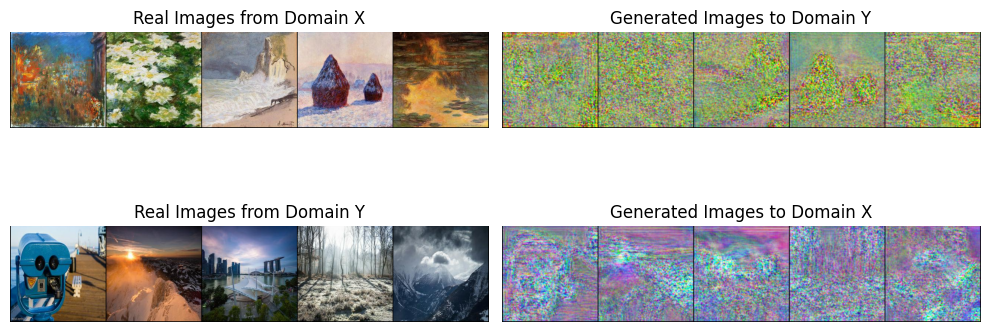

In [14]:
#Print Sample Before Training
cyclegan.sample_images(real_X, real_Y)
cyclegan.save_model("monet_cyclegan_model.pth")
torch.cuda.empty_cache()

Epoch: 0/90, Batch: 0/1, Generator LR: 0.000100, Discriminator X LR: 0.000100, Discriminator Y LR: 0.000100, Generator Loss: 4.3860, Discriminator X Loss: 0.6780, Discriminator Y Loss: 0.7379


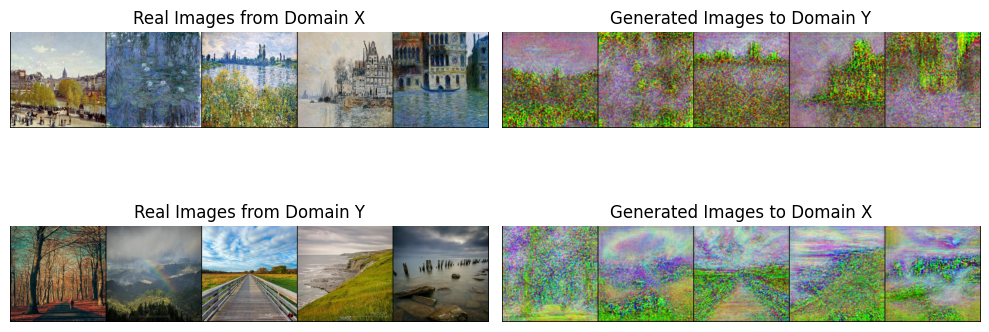

Epoch: 1/90, Batch: 0/1, Generator LR: 0.000100, Discriminator X LR: 0.000100, Discriminator Y LR: 0.000100, Generator Loss: 3.4290, Discriminator X Loss: 0.7579, Discriminator Y Loss: 0.8715
Epoch: 2/90, Batch: 0/1, Generator LR: 0.000100, Discriminator X LR: 0.000100, Discriminator Y LR: 0.000100, Generator Loss: 3.4166, Discriminator X Loss: 0.8582, Discriminator Y Loss: 0.7205
Epoch: 3/90, Batch: 0/1, Generator LR: 0.000100, Discriminator X LR: 0.000100, Discriminator Y LR: 0.000100, Generator Loss: 2.4466, Discriminator X Loss: 0.3338, Discriminator Y Loss: 0.3562
Epoch: 4/90, Batch: 0/1, Generator LR: 0.000100, Discriminator X LR: 0.000100, Discriminator Y LR: 0.000100, Generator Loss: 2.0714, Discriminator X Loss: 0.3484, Discriminator Y Loss: 0.3862
Epoch: 5/90, Batch: 0/1, Generator LR: 0.000100, Discriminator X LR: 0.000100, Discriminator Y LR: 0.000100, Generator Loss: 1.8175, Discriminator X Loss: 0.3058, Discriminator Y Loss: 0.3323
Epoch: 6/90, Batch: 0/1, Generator LR: 0

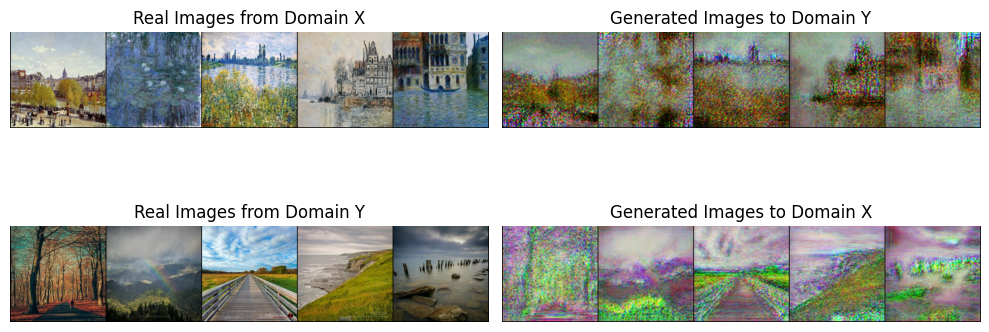

Epoch: 11/90, Batch: 0/1, Generator LR: 0.000100, Discriminator X LR: 0.000100, Discriminator Y LR: 0.000100, Generator Loss: 1.5990, Discriminator X Loss: 0.3246, Discriminator Y Loss: 0.3118
Epoch: 12/90, Batch: 0/1, Generator LR: 0.000100, Discriminator X LR: 0.000100, Discriminator Y LR: 0.000100, Generator Loss: 1.6959, Discriminator X Loss: 0.2925, Discriminator Y Loss: 0.3067
Epoch: 13/90, Batch: 0/1, Generator LR: 0.000100, Discriminator X LR: 0.000100, Discriminator Y LR: 0.000100, Generator Loss: 1.7129, Discriminator X Loss: 0.3110, Discriminator Y Loss: 0.2874
Epoch: 14/90, Batch: 0/1, Generator LR: 0.000100, Discriminator X LR: 0.000100, Discriminator Y LR: 0.000100, Generator Loss: 1.6673, Discriminator X Loss: 0.3297, Discriminator Y Loss: 0.2700
Epoch: 15/90, Batch: 0/1, Generator LR: 0.000100, Discriminator X LR: 0.000100, Discriminator Y LR: 0.000100, Generator Loss: 1.5097, Discriminator X Loss: 0.3204, Discriminator Y Loss: 0.2912
Epoch: 16/90, Batch: 0/1, Generator

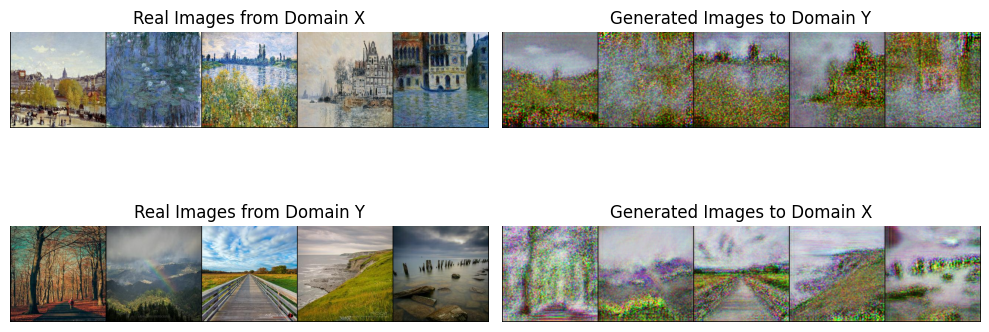

Epoch: 21/90, Batch: 0/1, Generator LR: 0.000100, Discriminator X LR: 0.000100, Discriminator Y LR: 0.000100, Generator Loss: 1.7520, Discriminator X Loss: 0.2769, Discriminator Y Loss: 0.3647
Epoch: 22/90, Batch: 0/1, Generator LR: 0.000100, Discriminator X LR: 0.000100, Discriminator Y LR: 0.000100, Generator Loss: 1.7411, Discriminator X Loss: 0.3214, Discriminator Y Loss: 0.4648
Epoch: 23/90, Batch: 0/1, Generator LR: 0.000100, Discriminator X LR: 0.000100, Discriminator Y LR: 0.000100, Generator Loss: 1.7430, Discriminator X Loss: 0.3487, Discriminator Y Loss: 0.4191
Epoch: 24/90, Batch: 0/1, Generator LR: 0.000100, Discriminator X LR: 0.000100, Discriminator Y LR: 0.000100, Generator Loss: 1.7620, Discriminator X Loss: 0.3399, Discriminator Y Loss: 0.2796
Epoch: 25/90, Batch: 0/1, Generator LR: 0.000100, Discriminator X LR: 0.000100, Discriminator Y LR: 0.000100, Generator Loss: 1.6203, Discriminator X Loss: 0.3186, Discriminator Y Loss: 0.2699
Epoch: 26/90, Batch: 0/1, Generator

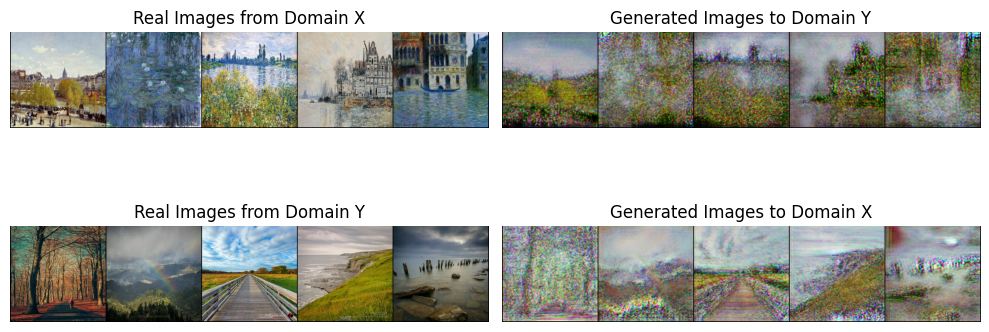

Epoch: 31/90, Batch: 0/1, Generator LR: 0.000100, Discriminator X LR: 0.000100, Discriminator Y LR: 0.000100, Generator Loss: 1.3934, Discriminator X Loss: 0.3011, Discriminator Y Loss: 0.2729
Epoch: 32/90, Batch: 0/1, Generator LR: 0.000100, Discriminator X LR: 0.000100, Discriminator Y LR: 0.000100, Generator Loss: 1.4004, Discriminator X Loss: 0.2966, Discriminator Y Loss: 0.2876
Epoch: 33/90, Batch: 0/1, Generator LR: 0.000100, Discriminator X LR: 0.000100, Discriminator Y LR: 0.000100, Generator Loss: 1.5309, Discriminator X Loss: 0.2566, Discriminator Y Loss: 0.2630
Epoch: 34/90, Batch: 0/1, Generator LR: 0.000100, Discriminator X LR: 0.000100, Discriminator Y LR: 0.000100, Generator Loss: 1.4020, Discriminator X Loss: 0.2877, Discriminator Y Loss: 0.2777
Epoch: 35/90, Batch: 0/1, Generator LR: 0.000100, Discriminator X LR: 0.000100, Discriminator Y LR: 0.000100, Generator Loss: 1.4034, Discriminator X Loss: 0.2989, Discriminator Y Loss: 0.2537
Epoch: 36/90, Batch: 0/1, Generator

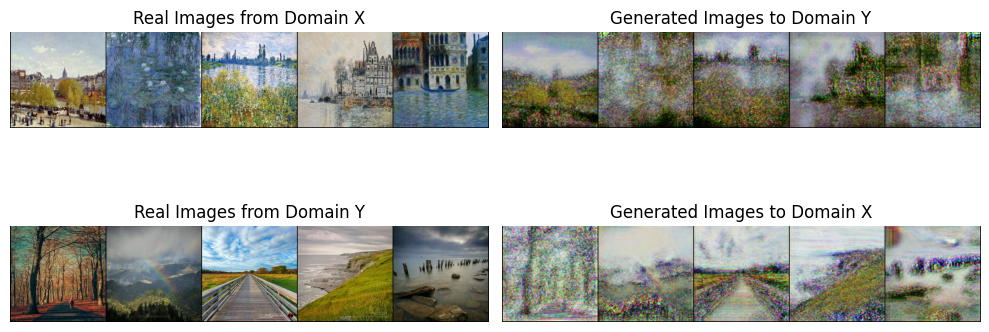

Epoch: 41/90, Batch: 0/1, Generator LR: 0.000098, Discriminator X LR: 0.000098, Discriminator Y LR: 0.000098, Generator Loss: 1.5936, Discriminator X Loss: 0.2420, Discriminator Y Loss: 0.2216
Epoch: 42/90, Batch: 0/1, Generator LR: 0.000096, Discriminator X LR: 0.000096, Discriminator Y LR: 0.000096, Generator Loss: 1.4767, Discriminator X Loss: 0.2717, Discriminator Y Loss: 0.2726
Epoch: 43/90, Batch: 0/1, Generator LR: 0.000094, Discriminator X LR: 0.000094, Discriminator Y LR: 0.000094, Generator Loss: 1.3877, Discriminator X Loss: 0.2570, Discriminator Y Loss: 0.2776
Epoch: 44/90, Batch: 0/1, Generator LR: 0.000092, Discriminator X LR: 0.000092, Discriminator Y LR: 0.000092, Generator Loss: 1.4567, Discriminator X Loss: 0.2724, Discriminator Y Loss: 0.2789
Epoch: 45/90, Batch: 0/1, Generator LR: 0.000090, Discriminator X LR: 0.000090, Discriminator Y LR: 0.000090, Generator Loss: 1.4200, Discriminator X Loss: 0.2808, Discriminator Y Loss: 0.2607
Epoch: 46/90, Batch: 0/1, Generator

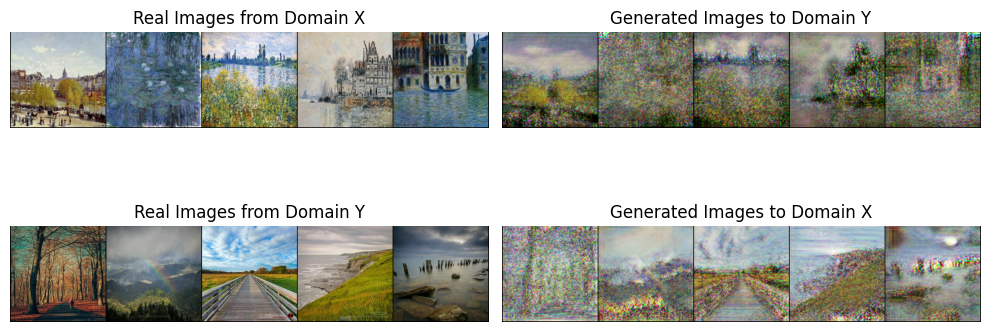

Epoch: 51/90, Batch: 0/1, Generator LR: 0.000078, Discriminator X LR: 0.000078, Discriminator Y LR: 0.000078, Generator Loss: 1.3366, Discriminator X Loss: 0.2612, Discriminator Y Loss: 0.2324
Epoch: 52/90, Batch: 0/1, Generator LR: 0.000076, Discriminator X LR: 0.000076, Discriminator Y LR: 0.000076, Generator Loss: 1.3704, Discriminator X Loss: 0.2587, Discriminator Y Loss: 0.2264
Epoch: 53/90, Batch: 0/1, Generator LR: 0.000074, Discriminator X LR: 0.000074, Discriminator Y LR: 0.000074, Generator Loss: 1.3126, Discriminator X Loss: 0.2772, Discriminator Y Loss: 0.2286
Epoch: 54/90, Batch: 0/1, Generator LR: 0.000072, Discriminator X LR: 0.000072, Discriminator Y LR: 0.000072, Generator Loss: 1.4082, Discriminator X Loss: 0.2725, Discriminator Y Loss: 0.1917
Epoch: 55/90, Batch: 0/1, Generator LR: 0.000070, Discriminator X LR: 0.000070, Discriminator Y LR: 0.000070, Generator Loss: 1.2875, Discriminator X Loss: 0.2766, Discriminator Y Loss: 0.2324
Epoch: 56/90, Batch: 0/1, Generator

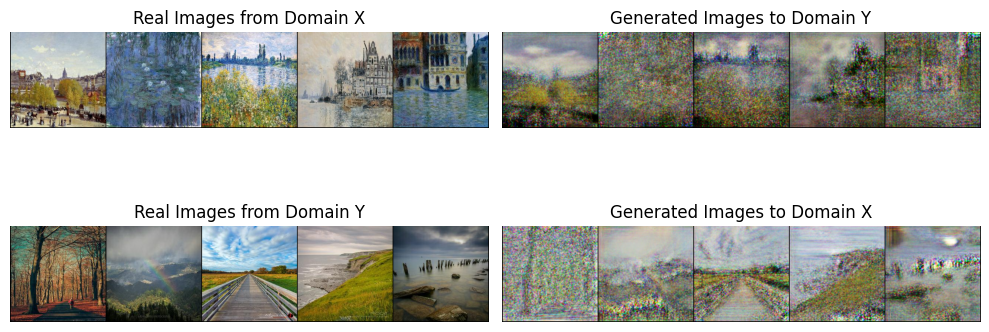

Epoch: 61/90, Batch: 0/1, Generator LR: 0.000058, Discriminator X LR: 0.000058, Discriminator Y LR: 0.000058, Generator Loss: 1.2369, Discriminator X Loss: 0.2802, Discriminator Y Loss: 0.2299
Epoch: 62/90, Batch: 0/1, Generator LR: 0.000056, Discriminator X LR: 0.000056, Discriminator Y LR: 0.000056, Generator Loss: 1.2780, Discriminator X Loss: 0.2717, Discriminator Y Loss: 0.2212
Epoch: 63/90, Batch: 0/1, Generator LR: 0.000054, Discriminator X LR: 0.000054, Discriminator Y LR: 0.000054, Generator Loss: 1.2767, Discriminator X Loss: 0.2687, Discriminator Y Loss: 0.2184
Epoch: 64/90, Batch: 0/1, Generator LR: 0.000052, Discriminator X LR: 0.000052, Discriminator Y LR: 0.000052, Generator Loss: 1.3376, Discriminator X Loss: 0.2705, Discriminator Y Loss: 0.1963
Epoch: 65/90, Batch: 0/1, Generator LR: 0.000050, Discriminator X LR: 0.000050, Discriminator Y LR: 0.000050, Generator Loss: 1.2400, Discriminator X Loss: 0.2751, Discriminator Y Loss: 0.2180
Epoch: 66/90, Batch: 0/1, Generator

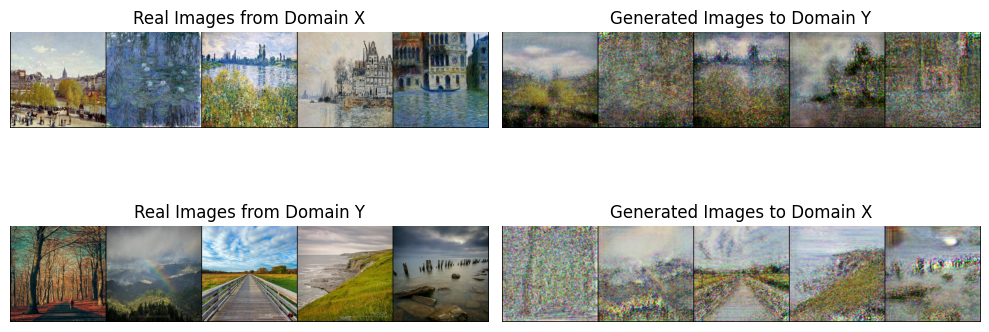

Epoch: 71/90, Batch: 0/1, Generator LR: 0.000038, Discriminator X LR: 0.000038, Discriminator Y LR: 0.000038, Generator Loss: 1.1814, Discriminator X Loss: 0.2816, Discriminator Y Loss: 0.2286
Epoch: 72/90, Batch: 0/1, Generator LR: 0.000036, Discriminator X LR: 0.000036, Discriminator Y LR: 0.000036, Generator Loss: 1.1845, Discriminator X Loss: 0.2794, Discriminator Y Loss: 0.2304
Epoch: 73/90, Batch: 0/1, Generator LR: 0.000034, Discriminator X LR: 0.000034, Discriminator Y LR: 0.000034, Generator Loss: 1.1871, Discriminator X Loss: 0.2837, Discriminator Y Loss: 0.2284
Epoch: 74/90, Batch: 0/1, Generator LR: 0.000032, Discriminator X LR: 0.000032, Discriminator Y LR: 0.000032, Generator Loss: 1.1759, Discriminator X Loss: 0.2821, Discriminator Y Loss: 0.2307
Epoch: 75/90, Batch: 0/1, Generator LR: 0.000030, Discriminator X LR: 0.000030, Discriminator Y LR: 0.000030, Generator Loss: 1.1971, Discriminator X Loss: 0.2831, Discriminator Y Loss: 0.2222
Epoch: 76/90, Batch: 0/1, Generator

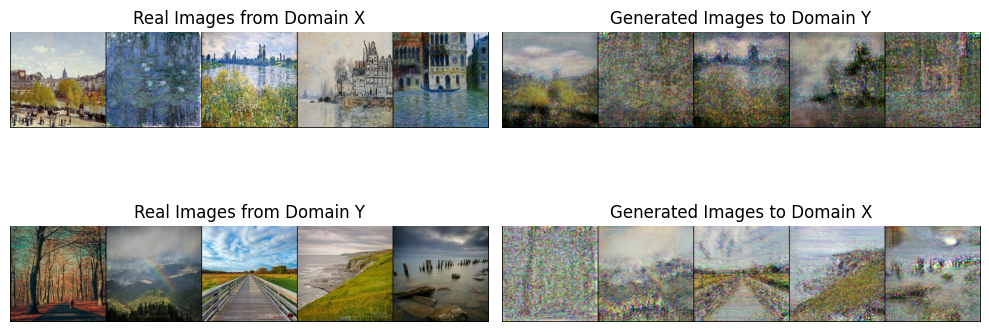

Epoch: 81/90, Batch: 0/1, Generator LR: 0.000018, Discriminator X LR: 0.000018, Discriminator Y LR: 0.000018, Generator Loss: 1.1437, Discriminator X Loss: 0.2828, Discriminator Y Loss: 0.2349
Epoch: 82/90, Batch: 0/1, Generator LR: 0.000016, Discriminator X LR: 0.000016, Discriminator Y LR: 0.000016, Generator Loss: 1.1414, Discriminator X Loss: 0.2843, Discriminator Y Loss: 0.2352
Epoch: 83/90, Batch: 0/1, Generator LR: 0.000014, Discriminator X LR: 0.000014, Discriminator Y LR: 0.000014, Generator Loss: 1.1402, Discriminator X Loss: 0.2852, Discriminator Y Loss: 0.2362
Epoch: 84/90, Batch: 0/1, Generator LR: 0.000012, Discriminator X LR: 0.000012, Discriminator Y LR: 0.000012, Generator Loss: 1.1402, Discriminator X Loss: 0.2848, Discriminator Y Loss: 0.2356
Epoch: 85/90, Batch: 0/1, Generator LR: 0.000010, Discriminator X LR: 0.000010, Discriminator Y LR: 0.000010, Generator Loss: 1.1406, Discriminator X Loss: 0.2851, Discriminator Y Loss: 0.2367
Epoch: 86/90, Batch: 0/1, Generator

In [24]:
cyclegan.train([next(iter(train_loader))], n_epoches, lr, beta1, beta2, decay_epoch)

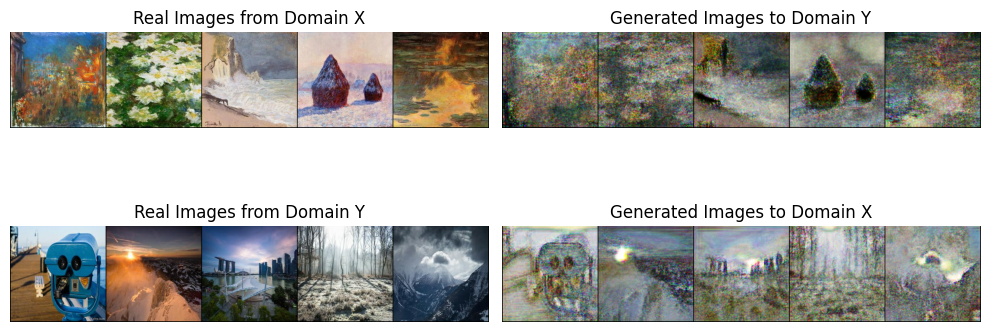

In [25]:
#Print Sample After Training
cyclegan.sample_images(real_X, real_Y)
cyclegan.save_model("monet_cyclegan_model.pth")
torch.cuda.empty_cache()

**Training on Entire Data Set**

In [ ]:
cyclegan.train(train_loader, n_epoches, lr, beta1, beta2, decay_epoch)
torch.cuda.empty_cache()

Epoch: 0/90, Batch: 0/50, Generator LR: 0.000100, Discriminator X LR: 0.000100, Discriminator Y LR: 0.000100, Generator Loss: 3.3452, Discriminator X Loss: 0.4229, Discriminator Y Loss: 0.3486
Epoch: 0/90, Batch: 10/50, Generator LR: 0.000100, Discriminator X LR: 0.000100, Discriminator Y LR: 0.000100, Generator Loss: 1.7452, Discriminator X Loss: 0.2524, Discriminator Y Loss: 0.2423
Epoch: 0/90, Batch: 20/50, Generator LR: 0.000100, Discriminator X LR: 0.000100, Discriminator Y LR: 0.000100, Generator Loss: 1.5874, Discriminator X Loss: 0.2678, Discriminator Y Loss: 0.2506


In [ ]:
#Print Sample After Model Training
cyclegan.sample_images(real_X, real_Y)
cyclegan.save_model("monet_cyclegan_model_final.pth")
torch.cuda.empty_cache()